# 02806 Social Data Analysis and Visualizations - Final project: NYPD Motor Vehicle Collision
## By David Frich Hansen, s144242 and Peter Edsberg Møllgaard s144256
#### 09/05-2017


## 1. Motivation
The dataset we have chosen is the NYPD Motor Collision Dataset available for free as Open City Data for New York City. The dataset, along with documentation can be found [here](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95 "NYPD Motor Vehicle Collisions"). The dataset is continuously updated. This project includes data over vehicle collisions from the 1st of July 2012 until the 31st of March 2017 inclusive. 

This is combined with weather data from the National Centers for Enviromental Information under NOAA, the National Oceanic and Atmospheric Administration. The used data can be found [here](https://www.ncdc.noaa.gov/cdo-web/datasets "NOAA Datasets") and is the Local Climatological Data, subset to only include the weather for the NYC Central Park Weather Station in the same time-period as the motor vehicle collision dataset.

Finally, to look at population densities we included data from [here](https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp "NTA Population Densities") which includes number of residents in each Neighborhood Tabulation Area in NYC. These are the smallest easily available areas for which population densities is released. Similarly, GeoJSON shapefiles for these NTAs can be found [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page "NTA GeoJSON Shapes").

We chose these datasets because they in combination allow us to take a look at some of the major causes and factors playing into car accidents, and whether or not these have consequences in terms of human life or human injuries. The raw NYPD-data allows us to investigate whether or not it's statistically more dangerous to ride a bike than to go by foot in different parts of the city, as well as allows us to determine whether or not weather plays a role in incidents. Finally, the population dataset allows us to look at specific places where accidents happen and hold this against how many people actually live here.

The goal with this analysis is to give the user (who is probably a resident of NYC) an idea as to whether or not he or she should grab his or her bike or go by foot depending on where they are. It should also be possible for them to look at the weather and then easily - based in the data - be able to asses the risk of being in a fatal accident. We should mention here, that the result of this particular part might be a bit off, as the classification is happening on the basis that the person is actually involved in an incident. However, as time is also included in this classification, it will still give the user an idea.

## 2. Basic statistics and data preprocessing

We load the data, and look at the columns. The DATE-attribute of each observation is converted to the built-in datetime-datastructure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt
%matplotlib inline


# Read data
collisions = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv', low_memory=False)

# Print columsn
print collisions.columns

# Create datetime index
Dates = pd.to_datetime(collisions['DATE'])


Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME',
       u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED',
       u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED',
       u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED',
       u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED',
       u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1',
       u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3',
       u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5',
       u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2',
       u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5'],
      dtype='object')


We then read the weather-data and select relevant columns. We also here ensure that the date is in the same format as in the NYPD-data as we want to merge the data-sets together.

Note that the original weather-data consists of hourly measurements as well as daily and monthly averages. We chose to work with daily averages, as this will probably give reasonable results. Future work could include choosing the correct hourly observation, but this requires significantly more data preprocessing, and this is time we unfortunately do not have.

In [2]:
# Prepare weather data with daily records instead of hourly
weather_full = pd.read_csv('CENTRALPARKWEATHERDATA.csv', low_memory=False)
weather_daily = weather_full[['DATE', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
                              'DAILYPrecip','DAILYSnowfall',
                              'DAILYSnowDepth', 'DAILYAverageWindSpeed']].copy()

weather_daily.dropna(axis=0, how='all', subset =['DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
                                                 'DAILYPrecip','DAILYSnowfall',
                                                 'DAILYSnowDepth', 'DAILYAverageWindSpeed'], inplace=True)

# Get dates in the right format
weather_daily_dates = pd.to_datetime(weather_daily['DATE'])
weather_daily = weather_daily.assign(DATEASSTRING = weather_daily_dates.copy().map(lambda x : x.strftime("%m/%d/%Y")))

# Drop original date label
weather_daily.drop('DATE', axis = 1, inplace=True)

# Get date in datetime-format
weather_daily = weather_daily.assign(DATEASDT = weather_daily_dates.copy().map(lambda x : x.date()))

# remove NaN's
weather_daily.dropna(axis=0 , how='any',subset=['DAILYMaximumDryBulbTemp', 'DAILYSnowfall'], inplace=True)



# Find missing dates in weather data
d = weather_daily_dates.map(lambda x : x.date()).tolist()
date_set = set(d[0] + dt.timedelta(x) for x in range((d[-1]-d[0]).days))
missing = sorted(date_set - set(d))
assert(len(missing) == 0)




Here we merge the two datasets on the date label and write it to csv. The columns are self-explanatory (DryMaximumBulbTemp and DryMinimumBulbTemp are simply max and min temperatures of the day), and are printed below.

In [3]:
# Join the NYPD-data and the weather-data on the date
weather_daily = weather_daily.rename(columns = {'DATEASSTRING' : 'DATE'})
full = pd.merge(collisions, weather_daily)

# write to csv
#full.to_csv('collisions_weather_merged.csv')

print full.columns

Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME',
       u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED',
       u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED',
       u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED',
       u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED',
       u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1',
       u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3',
       u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5',
       u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2',
       u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5',
       u'DAILYMaximumDryBulbTemp', u'DAILYMinimumDryBulbTemp', u'DAILYPrecip',
       u'DAILYSnowfall', u'DAILYSnowDepth', u'DAILYAverageWindSpeed',
       u'DATEASDT'],
      dtype='object')


We want to look at the basic stats of the collisions dataset.

To do this, we look at some different counts. The counts are
 * Incidents pr. day
 * Incidents pr. year
 * Incidents pr. hour
 * Injuries pr. hour
 * Deaths pr. hour
 * Count of causes, where available, out of total amount of incidents

 
In our video-introduction, we also thought about introducing some causes into the analysis, but we chose not to do it after all. This is due to the fact, that a lot of causes were missing in the dataset and this would limit the certainty in the results. Thus we introduced the weather-data instead. 
 

Count incidents pr. day and export to JSON for fast proccesing in D3.js.

In [4]:
# Create json for incidents pr. day
collisions_heat = pd.Series([1 for i in range(collisions.shape[0])], index = Dates)
dateCount = collisions_heat.groupby(collisions_heat.index.date).count()
dateCount = pd.DataFrame(dateCount)
dateCount = dateCount.assign(date=dateCount.index.map(lambda x : x.strftime("%Y-%m-%d")))
dateCount.columns = ['count', 'date']
dateCount.to_json('Collisions_per_day.json', orient = "records")

Count incidents pr. year and export to JSON for fast proccesing in D3.js

In [5]:
# Create json for incidents pr. year
def getYear(string):
    return int(string.split('/')[-1])
year = collisions.DATE.map(getYear)

# Count number of incidents
cYear = sorted(Counter(year).items(), key= lambda x : x[0])

# Export to JSON
index, count = zip(*cYear)

collisionsYear = pd.DataFrame()
collisionsYear = collisionsYear.assign(indeces=index)
collisionsYear = collisionsYear.assign(count=count)
collisionsYear.to_json('incidents_per_year.json', orient = "records")

Count incidents pr. hour and export to JSON for fast proccesing in D3.js

In [6]:
# Create json for incidents pr hour
def getHour(string):
    return int(string.split(':')[0])

# Count number of injures
hour = collisions.TIME.map(getHour)
cHour = sorted(Counter(hour).items(), key = lambda x : x[0])

# Export to JSON
index, count = zip(*cHour)

collisionsHour = pd.DataFrame()
collisionsHour = collisionsHour.assign(indeces = index)
collisionsHour = collisionsHour.assign(count=count)
collisionsHour.to_json('incident_per_hour.json', orient='records')

Count injuries pr. hour and export to JSON for fast proccesing in D3.js

In [7]:
# create json for injuries pr. hour
collisions = collisions.assign(HOUR = hour)
collisionsTimesInjuries = collisions[['NUMBER OF PERSONS INJURED', 'HOUR']]
collisionsTimesInjuries = collisionsTimesInjuries.loc[collisionsTimesInjuries['NUMBER OF PERSONS INJURED'] > 0]

# Count amount of injuries
cHourInj = sorted(Counter(collisionsTimesInjuries.HOUR).items(), key = lambda x : x[0])

# Export to JSON
index, count = zip(*cHourInj)

collisionsTimesInjuries = pd.DataFrame()
collisionsTimesInjuries = collisionsTimesInjuries.assign(indeces = index)
collisionsTimesInjuries = collisionsTimesInjuries.assign(count = count)
collisionsTimesInjuries.to_json('injuries_per_hour.json', orient='records')



Count deaths pr. hour and export to JSON for fast proccesing in D3.js

In [8]:
# create json for deaths pr. hour
collisionsTimesKilled = collisions[['NUMBER OF PERSONS KILLED', 'HOUR']]
collisionsTimesKilled = collisionsTimesKilled.loc[collisionsTimesKilled['NUMBER OF PERSONS KILLED'] > 0]

# Count number of deaths
cHourDeath = sorted(Counter(collisionsTimesKilled.HOUR).items(), key = lambda x : x[0])

# Export to JSON
index, count = zip(*cHourDeath)

collisionsTimesKilled = pd.DataFrame()
collisionsTimesKilled = collisionsTimesKilled.assign(indeces = index)
collisionsTimesKilled = collisionsTimesKilled.assign(count = count)
collisionsTimesKilled.to_json('deaths_per_hour.json', orient='records')

Count the causes - which causes are more prevalent? Then export to JSON for fast proccesing in D3.js

In [9]:
# Causes of traffic incidents
collisionsCauses = collisions[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']]
collisionsCauses = collisionsCauses['CONTRIBUTING FACTOR VEHICLE 1'].append(collisionsCauses['CONTRIBUTING FACTOR VEHICLE 2']).append(collisionsCauses['CONTRIBUTING FACTOR VEHICLE 3']).append(collisionsCauses['CONTRIBUTING FACTOR VEHICLE 4']).append(collisionsCauses['CONTRIBUTING FACTOR VEHICLE 5'])
collisionsCauses = collisionsCauses.loc[collisionsCauses != 'Unspecified']
collisionsCauses = collisionsCauses.dropna()

# Count occurences of each cause
CCauses = sorted(Counter(collisionsCauses).items(), key = lambda x : x[1])

# Export to json
index, count = zip(*CCauses)

collisionsCauses = pd.DataFrame()
collisionsCauses = collisionsCauses.assign(indeces = index)
collisionsCauses = collisionsCauses.assign(count = count)
collisionsCauses.to_json('incidents_causes.json', orient='records')

We also want to do some interactive visualizations over the frequency of incidents in the different NTAs, but this data is not readily available. The below script, edited from [here](https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python) counts the amount of incidents in each NTA and exports to JSON to handle in D3.js.

In [10]:
# Geodata for Chloropeth


#Edited from https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python
import geopandas
from shapely.geometry import Point

df = collisions.dropna(axis=0, how='any', subset=['LONGITUDE', 'LATITUDE'], inplace=False)[['LONGITUDE', 'LATITUDE']]

#Creating a shapefile containing Lon Lat of incidents
geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
df = df.drop(['LONGITUDE', 'LATITUDE'], axis=1)
crs = {'init': 'epsg:4326'}

#Calculating which NTA each incidents belong in
points = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
poly  = geopandas.GeoDataFrame.from_file('ntasWPop.shp')
from geopandas.tools import sjoin
pointInPolys = sjoin(points, poly, how='left')
grouped = pointInPolys.groupby('index_right')

#Counting the amount of incidents in each NTA
data = list(grouped)
liste = [[],[]]
for i in range(len(data)):
    liste[0].append(str(data[i][1].NTAName.iloc[0]))
    liste[1].append(len(data[i][1].NTAName))
    
    
df_incidents_per_NTA = pd.DataFrame()
df_incidents_per_NTA = df_incidents_per_NTA.assign(NTAName=liste[0])
df_incidents_per_NTA = df_incidents_per_NTA.assign(count=liste[1])

The following combines 2 of the datasets mentioned in the introduction. It combines the NTA GeoJSON-shapes with the US Census 2010 dataset over the population in the NTAs. It then exports this to a JSON for handling in D3.js. It should be noted that the file is then converted to the TopoJSON format (via [mapshaper.org](http://mapshaper.org)) for handling in the visualizations in D3 v4.

In [11]:
# Population data for density plots

import json

with open('./Population/ntas.geojson') as f:
    ntaShapes = json.load(f)
    # Number of NTA's
    num = len(ntaShapes['features'])    
    # Read population data
    popData = pd.read_csv('./Population/population.csv', low_memory=False)
    # Get only data from 2010
    popData = popData.loc[popData['Year'] > 2001]
    # For each NTA
    for nta in range(num):
        # Get name of NTA
        name = ntaShapes['features'][nta]['properties']['NTAName']
        
        # Find the name in population data
        row = popData.loc[popData['NTA Name'] == name]
        
        # Amount of incidents
        inc = df_incidents_per_NTA[df_incidents_per_NTA['NTAName']==name]['count'].tolist()
        
        # If row is empty
        if row.empty:
            ntaShapes['features'][nta]['properties']['population'] = str(0)
            ntaShapes['features'][nta]['properties']['count'] = str(inc)
        else:
            # Get population in that NTA
            pop = row['Population'].tolist()[0]

            # Set that value in the json
            ntaShapes['features'][nta]['properties']['population'] = str(pop)
            ntaShapes['features'][nta]['properties']['count'] = str(inc)
    # dump json
    with open('ntasWPop.json', 'w') as out:
        json.dump(ntaShapes, out)

The basic distributions of the data can be seen on the webpage as barplots.

We will comment them here.

An interesting thing is that, one might assume that the general tendency of incidents would be dropping. This, however, doesn't seem to be the case. Rather it seems that the rate is constant over the years. Similarly, one can on the first visualization of the webpage see that this seems rahter constant, down to the daily level. This discouraged us from using that attribute in the data analysis. Rather it seems that the time of day plays a role, as more incidents happen in rush hours. This follows along pretty well with the number of injuries and number of people killed at these times - the distributions actually imply high multicollinearity between these attributes. This we circumvent by
1. Not doing multiple linear regression in which case, we'd uderestimate the variance of the parameters
2. In cases where this might be a problem use proper bootstrapping methods to avoid this.

This leaves us with location, injuries (and deaths) and the weather data to do the analysis. This can be seen below.

## 3. Theory and analysis

Now that we've established some sort of foundation to begin the analysis, this can actually commence.

### KNN to determine decision boundaries to determine whether or not walking or biking in different parts of NYC is more safe
One of our goals is to determine whether or not some areas in NYC are more dangerous if you're on bike or if your on foot. In Machine Learning terms we want to determine the the *decision boundaries* in a classification task. As we have geodata available and we assume that in specific areas it's more likely to get an injury if your on bike. Thus we use $K$-nearest neighbors.

One major flaw in approach is that we do not have information on the involved people in cases where no one was injured or killed. This significantly weakens our results as we now only look at "more dangerous areas, given that you someone is injured in an accident". However, it might not be too harsh to assume that this generalizes to cases where no one was injured.

Another issue is the true classes. How do we determine what it means to be "more dangerous"?
We use a simple approach. We look at the incidents where either a pedestrian or cyclist is injured or killed. Then we count the amount in each case and choose whatever is bigger. In case of ties they are assigned a third label, indicating this. Then the geodata is used to train a KNN Classifier.

Prepare data for KNN

In [12]:
# Remove observations not in NYC
collisions = collisions[np.abs(collisions.LONGITUDE-collisions.LONGITUDE.mean())<=(2.05*collisions.LONGITUDE.std())]
collisions = collisions[np.abs(collisions.LATITUDE-collisions.LATITUDE.mean())<=(2.05*collisions.LATITUDE.std())]


# Create dataframe with locations, number of pedestrians injured/killed and number of cyclists injured or killed
bikeOrWalk = collisions[(collisions['NUMBER OF PEDESTRIANS INJURED'] != 0) | (collisions['NUMBER OF PEDESTRIANS KILLED'] != 0) |
                       (collisions['NUMBER OF CYCLIST KILLED'] != 0) | (collisions['NUMBER OF CYCLIST INJURED'] != 0)] 
# Select columns
bikeOrWalk = bikeOrWalk[['LONGITUDE', 'LATITUDE', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
                         'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]

# Remove NaNs from location
bikeOrWalk.dropna(axis=0, how='any', subset=['LONGITUDE', 'LATITUDE'], inplace=True)


# Select categories for each observation based on the amount of people injured or killed.
cat = []
pedsIL = bikeOrWalk['NUMBER OF PEDESTRIANS INJURED'].tolist()
pedsKL = bikeOrWalk['NUMBER OF PEDESTRIANS KILLED'].tolist()
cycsIL = bikeOrWalk['NUMBER OF CYCLIST INJURED'].tolist()
cycsKL = bikeOrWalk['NUMBER OF CYCLIST KILLED'].tolist()

for i in range(bikeOrWalk.shape[0]):
    peds = pedsIL[i] + pedsKL[i]
    cycs = cycsIL[i] + cycsKL[i]
    if peds < cycs:
        cat.append('Cyclist accident.')
    elif cycs < peds:
        cat.append('Pedestrian accident.')
    else:
        cat.append('Both.')

bikeOrWalk = bikeOrWalk.assign(CATEGORY = cat)

Below is a function that takes as input a number of folds, $d$ (explained in a bit) and a max number of neighbors. 

Then it uses a Grid Search Cross Validation approach to determine the optimal value for $k$ and prints it. The splitting strategy used is stratified $d$-fold CV which splits the dataset into $d$ subsets, which are all precomputed to have app. the same amount of each label (which distinguishes stratified $d$-fold CV from regular $d$-fold CV). Then a KNN is trained on $d-1$ of the subsets (training sets) and tested on the last. Then a generalization error is computed and saved. This is done for all the datasets and then the mean generalization error is computed. 

This is done for all candidates for $k$ defined as $k = 1,2,\ldots maxNeighbors$. The optimal choice for $k$ is then the one with the lowest mean generalization error.

When this is done, the function fits a new KNN with the optimal $k$ and predicts a grid over NYC to determine decision boundaies for the problem. This is then plotted on a map using Geoplotlib. The fineness of the grid is determined by the parameter gridSize.

The accuracy of the optimal fit is evaluated as the fraction of correctly predicted labels. This is also printed.

In [13]:
import sklearn.neighbors as nb
import geoplotlib as gpl
from sklearn import model_selection
# Function that trains a KNN-classifier, cross-validates the number of neighbors using a grid-search strategy and 
# plots a map, as geodata is used
def KNNClassify(d = 10, maxNeighbors = 10, plot=True, gridSize=75):
    

    # Y as target
    Y, YLabels = pd.factorize(bikeOrWalk.CATEGORY)
        
    
    # X as features (ie. location)
    X = zip(bikeOrWalk.LONGITUDE.tolist(), bikeOrWalk.LATITUDE.tolist())
    X = np.asarray(X).astype(np.float)
    
    # Grid for the parameter
    grid = {'n_neighbors': np.arange(1, maxNeighbors + 1)}
    # Cross-validate with accuracy as metric using stratified K fold as splitting strategy.
    cv_Res = model_selection.GridSearchCV(nb.KNeighborsClassifier(), grid, scoring=None, 
                                          fit_params=None, n_jobs=-1, 
                                          iid=False, refit=True, cv=d, 
                                          verbose=1, pre_dispatch='2*n_jobs', 
                                          error_score='raise', return_train_score=True)
    
    # Fit best model
    cv_Res.fit(X, Y)
    # Best parameter
    neigh = cv_Res.best_estimator_
    k_opt = cv_Res.best_params_
    print "Best parameter: " + str(k_opt)
   
    # Print mean accuracy
    acc = neigh.score(X, Y)
    print "Accuracy: " + str(acc)
    
    # Set boundaries for plot
    north=np.amax(collisions.LATITUDE)
    west=np.amin(collisions.LONGITUDE)
    south=np.amin(collisions.LATITUDE)
    east=np.amax(collisions.LONGITUDE)
    y_max = north
    x_max = east
    y_min = south
    x_min = west

    
    
    # Create grid for prediction with size gridSize x gridSize. Constants chosen by trial and error
    gridX = np.linspace(x_min, x_max, gridSize)
    gridY = np.linspace(y_min, y_max, gridSize)
    xx, yy = np.meshgrid(gridX, gridY)
    
    # Predict on the grid
    Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Take out 3 dictionaries for plotting geodata
    index = {'class1':{'lon': [],'lat': []},'class2':{'lon': [],'lat': []},'class3':{'lon': [],'lat': []}}
    class_name = ['class1','class2','class3']
    step_size_lon = (x_max - x_min)/gridSize
    step_size_lat = (y_max - y_min)/gridSize
    for i in range(len(gridX)):
        for j in range(len(gridY)):
            index[class_name[Z[j][i]]]['lon'].append(x_min+step_size_lon*i)
            index[class_name[Z[j][i]]]['lat'].append(y_min+step_size_lat*j)
    if plot:

        # Plot grid
        gpl.dot(index['class1'], color=[255,255,0])
        gpl.dot(index['class2'], color=[255,0,0])
        gpl.dot(index['class3'], color=[0,255,0])

        gpl.set_bbox(gpl.utils.BoundingBox(north=north, south=south, east=east, west=west))
        gpl.inline()

    return index

    
    


In the cell below, we run the model with a max number of neighbors of 50 and for each candidate splitting in 20 folds. This yields a total of $20\cdot 50 = 1000$ fits for the algorithm. This is run by parallel computing. As indicated by the output we the optimal value for $k$ in our dataset is $k=36$ and the accuracy in this case is $0.74$, indiating that our classifier is right $\sim 74\%$ of the time, making it much better than a random guess. The map is shown below, where the yellow parts indicate that it's more dangerous to walk than to bike and red parts indicate that it's more dangerous to bike. No parts of the map are classified as equal probability. This might be due to the fact, that this class is much smaller than the others. 

This can be 'solved' by normalizing the dataset wrt. the classes. This will however, only be good for relative classification, which is not what we're interested in here.

Below we run the function and collect the results and export to JSON for visualizing in D3.js.

In [15]:
resKNN = KNNClassify(d=20, maxNeighbors=50, gridSize=85, plot=True)

c1 = pd.DataFrame()
c1 = c1.assign(longitude = resKNN['class1']['lon'])
c1 = c1.assign(latitude = resKNN['class1']['lat'])
c1 = c1.assign(cl = np.ones_like(c1.latitude, dtype=int))


c2 = pd.DataFrame()
c2 = c2.assign(longitude = resKNN['class2']['lon'])
c2 = c2.assign(latitude = resKNN['class2']['lat'])
c2 = c2.assign(cl = 2*np.ones_like(c2.latitude, dtype=int))

c3 = pd.DataFrame()
c3 = c3.assign(longitude = resKNN['class3']['lon'])
c3 = c3.assign(latitude = resKNN['class3']['lat'])
c3 = c3.assign(cl = 3*np.ones_like(c3.latitude, dtype=int))


# Merge dataframes
resKNN = pd.concat([c1, c2, c3])
resKNN.index = range(len(resKNN.index))
resKNN.columns = ['longitude', 'latitude', 'class']
# Export to json
resKNN.to_json('./resultKNN.json', orient='records')


Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


Best parameter: {'n_neighbors': 36}
Accuracy: 0.736343253159


### Decision trees
Another thing we want to accomplish is to determine how the weather influences the fatality of incidents. 

Recall that we added the daily weather to the collision data. This allows us to use decision trees to predict the result of accidents, *given* that they happen. That is, if you are in an accident, what are your odds given the current weather conditions?

Is there a larger risk of dying if there's lying snow on the ground? This is what decision trees help us discover. 

Thus we actually predict what your odds are *given* your in an accident. This is **not** the same as determining the connection between weather and the frequency of accidents. This is not done due to the clear intuition behind the result. One can easily (probably justified) assume that more incidents occur when the weather conditions are bad (low visibility, snow on the ground etc.)

A problem with decision trees are their tendency to overfit the data - that is, we should prune the tree to avoid capturing random variations in the data in trade for lower test error. To avoid this, we adopt a common approach. Instead of fitting a single decision tree we fit a so-called *Random Forest Model* which is an ensemble classifier. 
Simply said, we sample the dataset many times with replacements and fit a decision tree on each tree. When predictions are performed, it is done on all trees and the class is chosen by either majority voting or by a weighting of relative probabilities of each class (as SciKit-Learn has implemented it). 

The random forest-models avoid problems like multicollinearity and doesn't depend on the strict restrictions that linear regression does. Decision trees can also handle different datatypes out of the bag.

Below we train a random forest model. We would've used cross validation to determine the optimal amount of trees in the forest. This, however, made Python run out of memory, so instead we look at the so-called OOB-score. This stands for "One out of bag-score" and looks at a datapoint $\boldsymbol{x}$ and evaluates it on all trees, for which is wasn't used as training data. The accuracy is evaluated and finally averaged. This is done across all points, and the average of this is called the OOB-score. 
Similarly the OOB-error is simply $1-OOB\:Score$. This can be used to evaluate the model fit. The right amount of trees can then be re-fitted. There are some theoretical considerations regarding OOB-scores. These can be read about in the [SciKit-learn documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html "SKLearn Documentation on OOB")

#### Train Random Forest
Before we can train the Random Forest Classifier, we'll preprocess the data, by ensuring they're the right datatype and by removing NaN's etc.
Once more we arrive at the problem with assigning a true label to the observations. We adopt the idea from before, where we assign a class depending on the count of people injured or killed.
This is done and we fit the classifier. 

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Select relevant columns
weather_accidents = full[['TIME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'DAILYMaximumDryBulbTemp',
                          'DAILYMinimumDryBulbTemp', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth', 'DAILYAverageWindSpeed']].copy()
weather_accidents = weather_accidents.assign(HOUR = weather_accidents.TIME.map(lambda x : int(x.split(':')[0])))
# Drop NaN's
weather_accidents = weather_accidents.dropna(how='any')

# Remove 'trace amounts' and set them to 0
weather_accidents = weather_accidents.replace(['T', 'Ts'], ['0', '0'])

# We need floats as datatype for classification
weather_accidents['DAILYMinimumDryBulbTemp'] = weather_accidents.DAILYMinimumDryBulbTemp.copy().astype(float)
weather_accidents['DAILYMaximumDryBulbTemp'] = weather_accidents.DAILYMaximumDryBulbTemp.copy().astype(float)
weather_accidents['DAILYPrecip'] = weather_accidents.DAILYPrecip.copy().astype(float)
weather_accidents['DAILYSnowfall'] = weather_accidents.DAILYSnowfall.copy().astype(float)
weather_accidents['DAILYSnowDepth'] = weather_accidents.DAILYSnowDepth.copy().astype(float)
weather_accidents['DAILYAverageWindSpeed'] = weather_accidents.DAILYAverageWindSpeed.copy().astype(float)

# Random forest instance
RFC = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                            max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=True, 
                            n_jobs=-1, random_state=123, verbose=1, warm_start=False, class_weight=None)
#RFC = model_selection.GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators' : np.arange(1, 150)}, 
#                                    verbose = 1, n_jobs=-1)

# Put into classes: "Risk of injury", "Risk of death", "Risk of injury or death", "Risk of involved in incident"
numInjured = weather_accidents['NUMBER OF PERSONS INJURED'].tolist()
numKilled = weather_accidents['NUMBER OF PERSONS KILLED'].tolist()
cat = []
for i in range(weather_accidents.shape[0]):
    if (numInjured[i] > 0) and (numKilled[i] == 0):
        cat.append('Risk of injury.')
    elif (numInjured[i] == 0) and (numKilled[i] > 0):
        cat.append('Risk of death.')
    elif (numInjured[i] > 0) and (numKilled[i] > 0):
        cat.append('Risk of injury or death.')
    else:
        cat.append('No injuries.')
weather_accidents = weather_accidents.assign(CLASS = cat)

# Matrix with attributes
X = weather_accidents[['HOUR', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth',
                       'DAILYAverageWindSpeed']].as_matrix()

# Train classifier
RFC.fit(X, weather_accidents.CLASS.tolist())


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=123,
            verbose=1, warm_start=False)

Below we calculate the OOB-errors for each candidate for the number of trees (to a reasonable degree). This is saved and the minimum value is computed and printed. The trace of the OOB-errors are plotted. The code below is modified from the [same example as before](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html). 

In [17]:
# OOB Visualization edited from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# Re-initialize instance
RFC = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                            max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=True, 
                            n_jobs=1, random_state=123, verbose=0, warm_start=True, class_weight=None)


error_rate = []
for i in range(10, 81):
    RFC.set_params(n_estimators=i)
    RFC.fit(X, weather_accidents.CLASS.tolist())
    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - RFC.oob_score_
    error_rate.append((i, oob_error))


C:\Program Files\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


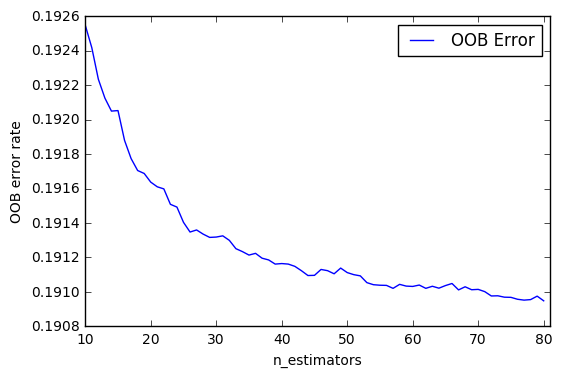

In [20]:
# Plot OOB Error
xs, ys = zip(*error_rate)
plt.plot(xs, ys, label='OOB Error')
plt.xlim(10, 81)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

#### Train single tree for visualization
The problem with Random Forests is that, although they might be better to classify, they're hard to interpret and hard to visualize. Because of this, we look at a single tree trained on the entire dataset. This is pruned heavily (due to space) and will thus not classify very well. This is simply done to create a nice, and interactive visualization for the webpage that is easy to interpret. 

Below is a function called "rules". This is taken directly from [planspace.org](http://planspace.org/20151129-see_sklearn_trees_with_d3/ "Planspace.org") and takes a decision tree instance from SciKit-learn and returns a nice JSON-like datastructure to create an interactive visualization in D3.js.

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Set max_leaf_nodes = 15 to avoid too large tree
singleTree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=2,
                                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                                    random_state=None, max_leaf_nodes=15, min_impurity_split=1e-07, 
                                    class_weight=None, presort=False)
singleTree.fit(X, weather_accidents.CLASS.tolist())


##### Function from http://planspace.org/20151129-see_sklearn_trees_with_d3/
def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier

    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.

    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        count_labels = zip(clf.tree_.value[node_index, 0], labels)
        node['name'] = ', '.join(('{} of {}'.format(int(count), label)
                                  for count, label in count_labels))
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['name'] = '{} > {}'.format(feature, threshold)
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
    return node

rls = rules(singleTree, ['HOUR', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYPrecip', 
                         'DAILYSnowfall', 'DAILYSnowDepth','DAILYAverageWindSpeed'], 
            weather_accidents.CLASS.unique().tolist())
with open('structure.json', 'w') as out:
    json.dump(rls, out)

## 4. Visualizations

The visualizations are mostly available on the website.

The first visualization on the website is one that allows the user to interactively inspect the amount of incidents on each day that the dataset spans. This allows the user to verify our claim that there's no significant change to the amount of collisions over the time-period. The visualization is interactive, so the user can inspect it in as much detail as he or she wants to.

The second visualization is chosen to allow the user to have an idea of the basic distributions of the data. To see that more incidents actually occur in rush hours when more people are in traffic etc.
Similarly it allows them to inspect the causes of the car incidents - although the majority of them are simply unspecified, and thus uninteresting and removed from the graph. Furthermore, it should be noted that in the cases of the amunts of deaths and injuries pr. hour we actually count the number of incidents where there's *at least* one injury or death.


The third visualization lets the user look at the difference between population densities and incident densities measured on the smallest available population 'units' in NYC - the NTAs. This allows a resident of NYC to look at their own neighborhood to determine if there's many incidents here compared to where they work. The colors are normalized wrt. area, so we get the true density in these regions. This allows them to determine whethter they live in a neighborhood with many or few incidents relative to the area of the neighborhood.


The fourth visualization is the same as in the KNN section above - simply in a D3.js framework. This allows the user to determine whether they should walk or bike to work/school depending on where they live. One could conclude that in general it's more dangerous to walk on Manhattan and more dangerous to bike in Brooklyn.


The final visualization is an example of a decision tree. This is chosen to introduce the user to the concept of random forests and to give them an intuition of the result of such an ensemble classifier. The results, however, are bad as mentioned above. The interpretation is that the user could look at the condition on each split and should go up if the observation they have fulfills that condition, and should go down if it doesn't. This should be continued until they reach a leaf, which will yield the prediction. This is also explained on the webpage.

## 5. Discussion

We managed to gain an understanding of the data regarding incidents of vehicle collisions. We managed to do a nice preproccessing and combine several datasets into one for analysis. The analysis, although a bit incoherent at times, fulfills the goal and gives some understanding of the data at hand. Similarly it allowed us to do some nice interactive visualizations that allowed us to tell a story of the data for the layman.
We also managed to gain a better understanding of how to do data visualizations efficiently and make them look nice and tidy.

On the other hand, we should've thought our analysis a bit more through before we began implementing it. Some of our results are somewhat useless, and would probably not be the first choice for someone asking. If we'd used more time discussing probabilities deeper we might have gotten some more interesting results. Things to mention could be to predict the frequency of incidents in bad weather and thus gaining an understanding of the weather's effect on car accidents. Another idea could be to include more machine learning methods that would allow to learn hotspots of traffic incidents unsupervised, or to look at different car types in different types of accidents.



### Sources

#### Datasets
 * https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95
 * https://www.ncdc.noaa.gov/cdo-web/datasets
 * https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp
 * https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page
 
#### Books
 * Data Science from Scratch: First Principles with Python. By Joel Grus. O'Reilly (2015). 
 * Interactive Data Visualization for the Web. By Scott Murray. O'Reilly (2013)
 
#### Online sources for scripts, ideas and theoretical considerations
 * http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
 * http://planspace.org/20151129-see_sklearn_trees_with_d3/
 * http://mapshaper.org
 * https://bl.ocks.org/misanuk/fc39ecc400eed9a3300d807783ef7607
 * http://stackoverflow.com/questions/42408265/plot-new-york-neighborhoods-with-d3-js
 * https://bl.ocks.org/d3noob/43a860bc0024792f8803bba8ca0d5ecd